# Main Game Logic v3.5
- Modified: 08 Apr 2025
- Adds map stitching
- Uses `parse_yaml` from strictjson (functionality to be added to AgentJo shortly after more testing!)
- Added Prediction, Insights, better Context
- Added Thoughts streaming

In [1]:
import os
os.getcwd()

'c:\\Users\\nicho\\Documents\\agentjo\\projects\\Pokemon\\Game'

In [2]:
# !pip install python-dotenv

In [3]:
from dotenv import load_dotenv
import time
from IPython.display import clear_output

# put your secret keys in your .env
# For instance, if you are using OpenAI, your .env should contain
# export OPENAI_API_KEY = "sk-......."
load_dotenv(override=True)

True

In [4]:
# !pip install google-genai

In [5]:
# !pip install strictjson

# Interface with AgentJo

In [6]:
# find agentjo from git repo without installing from pip
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '../../')))
# # you still need to install strictjson though

from agentjo import parse_yaml

In [7]:
def replace_image_marker_gemini(func):
    """
    A decorator that scans the user prompt for markers in the form <<filename>>.
    For each marker, it attempts to load an image either from a local file (e.g., .png, .jpg, etc.)
    or from an HTTP URL, and replaces the marker with the corresponding image object.
    Local images are loaded via PIL.Image, while HTTP images are fetched using requests
    and wrapped as a types.Part for the Gemini API.
    The resulting list (mixing text and images) is passed to the wrapped function.
    """
    def wrapper(system_prompt: str, user_prompt: str, **kwargs):
        import re
        parts = re.split(r'<<(.*?)>>', user_prompt)
        new_contents = []
        for idx, part in enumerate(parts):
            if idx % 2 == 1:
                image_source = part.strip()
                # Check if the marker is an HTTP(S) URL.
                if image_source.startswith("http://") or image_source.startswith("https://"):
                    try:
                        import requests
                        response = requests.get(image_source)
                        response.raise_for_status()
                        from google.genai import types
                        # Try to get the MIME type from the response headers; default to image/jpeg.
                        mime_type = response.headers.get("Content-Type", "image/jpeg")
                        new_contents.append(types.Part.from_bytes(data=response.content, mime_type=mime_type))
                    except Exception as e:
                        # If fetching the image fails, leave the marker as text.
                        new_contents.append(f"<<{part}>>")
                else:
                    try:
                        from PIL import Image
                        image = Image.open(image_source)
                        new_contents.append(image)
                    except Exception as e:
                        new_contents.append(f"<<{part}>>")
            else:
                if part:
                    new_contents.append(part)
        return func(system_prompt, new_contents, **kwargs)
    return wrapper

@replace_image_marker_gemini
def llm(system_prompt: str, user_prompt, **kwargs):
    """
    Calls the Gemini API. If the user_prompt has been processed into a list (via our decorator),
    it is used directly as the contents; otherwise, the user_prompt is wrapped in a list.
    """
    from google.genai import types
    from google import genai
    import os

    client = genai.Client(api_key=os.environ['GEMINI_API_KEY'])

    # Use the user_prompt directly if it's a list, otherwise wrap it.
    contents = user_prompt if isinstance(user_prompt, list) else [user_prompt]

    response = client.models.generate_content(
        model="gemini-2.0-flash",
        config=types.GenerateContentConfig(system_instruction=system_prompt, temperature=0),
        contents=contents
    )
    return response.text

In [8]:
import requests
import base64
from PIL import Image
from io import BytesIO
from IPython.display import display
import os

BASE_URL = os.environ['BASE_URL']

# Initialize the game
# requests.post(f"{BASE_URL}/init", json={"rom_path": "PokemonRed.gb"})

count = 0

conversation = []
context_schema = {"Long-term Goals": "State your overall goals to win the game, be detailed and specific, list",
"Short-term Goal": "State what you are trying to do now, be detailed and specific. Describe in detail how the game will be when the goal is completed",
"Target Object or Menu Option to Navigate to": "State the target object in grid world or target menu option you are trying to navigate to, NA if nothing",
"Important Information": "Important knowledge about the world that can help with goals",
"Inventory": "Important items in inventory to help with goals",
"Grid Coordinates Visited": "Update with Current Coordinates, list",
"Map Transition Coordinates": "Updated with (map_id, x, y) -> (map_id, x, y) whenever a map_id is changed, list",
"List of NPCs Interacted": "NPCs who you have interacted with in the form of Person_Name (map_id, x, y) - Summary of Dialogue, list",
"List of Insights Gained": "Write what you have learned from your actions to help you to repeat good actions and avoid repeating bad ones. Be specific and write down full context, list"}
context = ''

# delete past images
from pathlib import Path
folder = Path("Images")
for file in folder.glob("*"):
    if file.is_file():  # Check if it's a file
        file.unlink()

In [9]:
## Main_Game_Logic_v3 loop with mapstitching

import pprint
import json
from Mapstitching.run_imagestitching import run_imagestitching
from Mapstitching.processimages import make_coordinates, convertPILToCV2

while True:
    # Get the current screen
    response = requests.get(f"{BASE_URL}/screen?format=base64")
    print(response)
    screen_data = response.json()["image"]
    screen_image_clean = Image.open(BytesIO(base64.b64decode(screen_data)))
    
    # Save the image in the specified directory with a filename that includes the current count
    screen_image_clean.save(f"Images/image_{count}.png")

    # Resize image and add the coordinate text (if not resized, font will be too low resolution to read)
    coord_img = make_coordinates(convertPILToCV2(screen_image_clean, color = True), font_scale=0.5, rescaleimg=5)
    screen_image = Image.fromarray(coord_img)

    # Stitch image to current map
    stitched_image_path, stitched_image = run_imagestitching(screen_image_clean)  # possible outputs: str: "INVALIDINPUT", "DIALOGUE", numpy.ndarray: image (new map), stitched image (found in existing map)

    if stitched_image_path in ["INVALIDINPUT", "DIALOGUE"]:
        print("No map found: Either input is invalid or current image is a dialogue/battle/shop dialouge")
        map_image = "No current map."
        addmap = ""
    else:
        map_image = f"<<{stitched_image_path[stitched_image_path.rindex('Maps'):]}>>"
        print("Map found at:", stitched_image_path)
        addmap = f"\nCurrent Map Image: {map_image}"
        display(Image.fromarray(stitched_image))


    # Get game state
    game_state = requests.get(f"{BASE_URL}/state").json()
    
    # Make a decision based on the state and screen
    # ... AI logic here ...
    res = parse_yaml('''Based on the image and game state, make a decision of what to do next.
If previous action did not match up to prediction, try other actions.

Coordinates are given as (map_id, x, y), map_id being the id of the current map, x being the left to right axis, y being the up to down axis
Every map as a unique map_id, if map_id changes, it is treated as changing location. You should explore the new location if it is unexplored.
left in the negative x direction, e.g. (map_id, x, y) to (map_id, x-1, y)
right in the positive x direction, e.g. (map_id, x, y) to (map_id, x+1, y),
up in the negative y direction, e.g. (map_id, x, y) to (map_id, x, y-1)
down in the positive y direction, e.g. (map_id, x, y) to (map_id, x, y+1)
a is typically used for confirming actions, selecting options, and interacting with elements in the game. You can only interact with elements right next to you.
b is typically used to cancel actions, go back to the previous screen, or exit menus
start is used to open the main menu, allowing players to access options like the Pokémon menu, bag, items, and settings
select is used to register key items, allowing players to quickly access them during gameplay

You can only enter or exit places via doors, ladders, cave holes, staircases.
If inside a house, you can exit via a rectangular floor rug and moving out of the house.
Black map boundaries are not traversable.
You are in red.

Be detailed in your explanations.
State whether the previous action is successful by seeing whether the predicted state is reflected in the Current State.
Generate Insights if any, to repeat successful actions or to prevent making bad actions.
Update the Current Context as Updated Context''',
    f'''```
Current State: {count}
Current Game Image: <<Images/image_{count}.png>>{addmap}
Current RAM State: {game_state}
Current Context: {context}
```
Last 100 Past States: {conversation[-100:]}''',
    output_format = {"Current View": "Enum['World Map', 'Dialogue', 'Menu', '2D Grid', 'Other']",
f"Description for State {count}": f'''Describe Current Game Image in detail for someone without the image to understand. 
Do not use details from previous Game Images.
Only state what is there and do not hallucinate. Highlight the important information relevant to the Goal or Target Object. 
If dialogue or menu or battle, highlight the options and status and where the cursor is pointing to.
If 2D grid view, state relative positions of all objects or NPCs with respect to the red player (you) using relative directions of top, bottom, left, right''',
                     f"Coordinates for State {count}": "State the (map_id, x, y) of Current RAM State",
                     f"Action for State {count-1}": "Write exactly previous action, if any",
                     f"Prediction for State {count}": "Write exactly previous prediction, if any",
                     "Is Action Successful": f"Whether the Prediction for State {count} matches the Coordinates for State {count} or Description for State {count}, bool",
                     "Reflection": "Reflect on why the action is successful or not successful",
                     "Thoughts": "Describe whether past actions are successful and how you plan to achieve your goal",
                     f"Action for State {count}": "Choose an action in line with Thoughts, Enum['up', 'down', 'left', 'right', 'a', 'b', 'start', 'select']",
                     f"Prediction for State {count+1}": "What will happen after the action is done. If it is a movement, state coordinates or menu option that we will expect to be in",
                     "Updated Context": context_schema},
                      llm = llm)

    # Update the context
    context = res["Updated Context"]
    
    next_move = res[f"Action for State {count}"]
    
    # Add in what happened in previous state in conversation history
    pprint.pprint(res, sort_dicts = False)

    # Show the thoughts
    thoughts = {'Current State': res[f'Description for State {count}'], 'Thoughts': res['Thoughts'], 'Action': res[f'Action for State {count}'], f'Prediction for State {count+1}': res[f'Prediction for State {count+1}']}
    requests.post(f"{BASE_URL}/agent/thoughts", json={"thought": json.dumps(thoughts, indent=4)})

    # Show the memory
    requests.post(f"{BASE_URL}/agent/memory", json={"memory": json.dumps(context, indent=4)})

    thoughts_internal = {f'Description for State {count}': res[f'Description for State {count}'], f'Thoughts for State {count}': res['Thoughts'], f'Action for State {count}': res[f'Action for State {count}'], f'Prediction for State {count+1}': res[f'Prediction for State {count+1}']}
    thoughts_internal[f"Game Image for State {count}"] = f"<<Images/image_{count}.png>>"
    conversation.append(json.dumps(thoughts_internal, indent=4))
                      
    # Increment count by 1 for the next image
    count += 1
    
    # Execute an action
    requests.post(f"{BASE_URL}/button", json={"button": next_move, "delay": 4})
    
    display(screen_image)

    print(game_state)
    
    time.sleep(5)
    clear_output(wait=True)

<Response [200]>
0 0 0 0
Image contains dialogue, skipping.
No map found: Either input is invalid or current image is a dialogue/battle/shop dialouge


KeyboardInterrupt: 

In [ ]:
## Main_Game_Logic_v3 loop for reference

import pprint
import json
while True:
    # Get the current screen
    response = requests.get(f"{BASE_URL}/screen?format=base64")
    print(response)
    screen_data = response.json()["image"]
    screen_image = Image.open(BytesIO(base64.b64decode(screen_data)))
    
    # Save the image in the specified directory with a filename that includes the current count
    screen_image.save(f"Images/image_{count}.png")
    
    # Get game state
    game_state = requests.get(f"{BASE_URL}/state").json()
    
    # Make a decision based on the state and screen
    # ... AI logic here ...
    res = parse_yaml('''Based on the image and game state, make a decision of what to do next.
If previous action did not match up to prediction, try other actions.

Coordinates are given as (map_id, x, y), map_id being the id of the current map, x being the left to right axis, y being the up to down axis
Every map as a unique map_id, if map_id changes, it is treated as changing location. You should explore the new location if it is unexplored.
left in the negative x direction, e.g. (map_id, x, y) to (map_id, x-1, y)
right in the positive x direction, e.g. (map_id, x, y) to (map_id, x+1, y),
up in the negative y direction, e.g. (map_id, x, y) to (map_id, x, y-1)
down in the positive y direction, e.g. (map_id, x, y) to (map_id, x, y+1)
a is typically used for confirming actions, selecting options, and interacting with elements in the game. You can only interact with elements right next to you.
b is typically used to cancel actions, go back to the previous screen, or exit menus
start is used to open the main menu, allowing players to access options like the Pokémon menu, bag, items, and settings
select is used to register key items, allowing players to quickly access them during gameplay

You can only enter or exit places via doors, ladders, cave holes, staircases.
If inside a house, you can exit via a rectangular floor rug and moving out of the house.
Black map boundaries are not traversable.
You are in red.

Be detailed in your explanations.
State whether the previous action is successful by seeing whether the predicted state is reflected in the Current State.
Generate Insights if any, to repeat successful actions or to prevent making bad actions.
Update the Current Context as Updated Context''',
    f'''```
Current State: {count}
Current Game Image: <<Images/image_{count}.png>>
Current RAM State: {game_state}
Current Context: {context}
```
Last 100 Past States: {conversation[-100:]}''',
    output_format = {"Current View": "Enum['World Map', 'Dialogue', 'Menu', '2D Grid', 'Other']",
f"Description for State {count}": f'''Describe Current Game Image in detail for someone without the image to understand. 
Do not use details from previous Game Images.
Only state what is there and do not hallucinate. Highlight the important information relevant to the Goal or Target Object. 
If dialogue or menu or battle, highlight the options and status and where the cursor is pointing to.
If 2D grid view, state relative positions of all objects or NPCs with respect to the red player (you) using relative directions of top, bottom, left, right''',
                     f"Coordinates for State {count}": "State the (map_id, x, y) of Current RAM State",
                     f"Action for State {count-1}": "Write exactly previous action, if any",
                     f"Prediction for State {count}": "Write exactly previous prediction, if any",
                     "Is Action Successful": f"Whether the Prediction for State {count} matches the Coordinates for State {count} or Description for State {count}, bool",
                     "Reflection": "Reflect on why the action is successful or not successful",
                     "Thoughts": "Describe whether past actions are successful and how you plan to achieve your goal",
                     f"Action for State {count}": "Choose an action in line with Thoughts, Enum['up', 'down', 'left', 'right', 'a', 'b', 'start', 'select']",
                     f"Prediction for State {count+1}": "What will happen after the action is done. If it is a movement, state coordinates or menu option that we will expect to be in",
                     "Updated Context": context_schema},
                      llm = llm)

    # Update the context
    context = res["Updated Context"]
    
    next_move = res[f"Action for State {count}"]
    
    # Add in what happened in previous state in conversation history
    pprint.pprint(res, sort_dicts = False)

    # Show the thoughts
    thoughts = {'Current State': res[f'Description for State {count}'], 'Thoughts': res['Thoughts'], 'Action': res[f'Action for State {count}'], f'Prediction for State {count+1}': res[f'Prediction for State {count+1}']}
    requests.post(f"{BASE_URL}/agent/thoughts", json={"thought": json.dumps(thoughts, indent=4)})

    # Show the memory
    requests.post(f"{BASE_URL}/agent/memory", json={"memory": json.dumps(context, indent=4)})

    thoughts_internal = {f'Description for State {count}': res[f'Description for State {count}'], f'Thoughts for State {count}': res['Thoughts'], f'Action for State {count}': res[f'Action for State {count}'], f'Prediction for State {count+1}': res[f'Prediction for State {count+1}']}
    thoughts_internal[f"Game Image for State {count}"] = f"<<Images/image_{count}.png>>"
    conversation.append(json.dumps(thoughts_internal, indent=4))
                      
    # Increment count by 1 for the next image
    count += 1
    
    # Execute an action
    requests.post(f"{BASE_URL}/button", json={"button": next_move, "delay": 4})
    
    display(screen_image)
    print(game_state)
    
    time.sleep(5)
    clear_output(wait=True)

<Response [200]>


KeyboardInterrupt: 

<Response [200]>


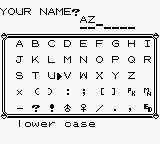

In [ ]:
# import json
# import requests
# import os
# from PIL import Image

# from io import BytesIO
# import base64
# from dotenv import load_dotenv
# import time
# from IPython.display import clear_output

# # put your secret keys in your .env
# # For instance, if you are using OpenAI, your .env should contain
# # export OPENAI_API_KEY = "sk-......."
# load_dotenv(override=True)

# BASE_URL = os.environ['BASE_URL']
# response = requests.get(f"{BASE_URL}/screen?format=base64")
# print(response)
# screen_data = response.json()["image"]
# screen_image = Image.open(BytesIO(base64.b64decode(screen_data)))
# display(screen_image)

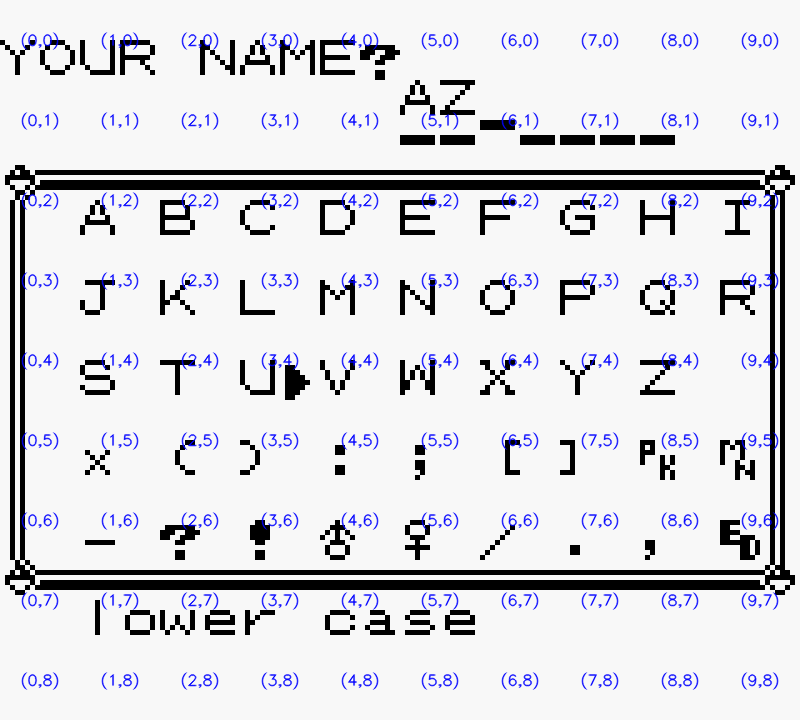

In [ ]:
# from Mapstitching.processimages import make_coordinates, convertPILToCV2
# import cv2
# coord_img = make_coordinates(convertPILToCV2(screen_image, color = True), font_scale=0.5, rescaleimg=5)
# converted = Image.fromarray(coord_img)
# converted.save(f"test_{1}.png")
# display(converted)